In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression, RANSACRegressor

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier

from sklearn.metrics import classification_report

from sklearn.svm import SVC, NuSVC, OneClassSVM

#### Functions used in the study.

In [3]:
# Dataset overview function
def check_df(dataframe, head=5):
    print("######################### SHAPE #########################")
    print(dataframe.shape)
    print("######################### DTYPES #########################")
    print(dataframe.dtypes)
    print("######################### NULL VALUES #########################")
    print(dataframe.isnull().sum())
    print("######################### INFO #########################")
    print(dataframe.info())
    print("######################### HEAD #########################")
    print(dataframe.head(head))
    print("######################### TAIL #########################")
    print(dataframe.tail(head))
    print("######################### DESCRIBE #########################")
    print(dataframe.describe().T)
    
# Check for unique values function
def check_uniques(dataframe):
    for col in dataframe.columns:
        print(' '*20)
        print(col.upper())
        print(dataframe[col].unique())
        
# Plot histogram function
def view_histogram(dataframe, columns = None):    
    num_columns = dataframe.select_dtypes(include=['int64','float64']).columns if columns is None else \
    columns
    
    for col in num_columns:    
        mean_value = dataframe[col]. mean()
        
        plt.figure(figsize=(5,5))
        plt.grid(True)
        plt.title(dataframe[col].name)
        sns.histplot(dataframe[col], kde=True)
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
        plt.legend()
        plt.show()
        
        print('Min:', dataframe[col].min())
        print('Max:', dataframe[col].max())
        print('Mean:', mean_value)
        print('Std:', dataframe[col].std())
        print('Skewness:', dataframe[col].skew())
        print('Kurtosis', dataframe[col].kurt())

# Show countplot function        
def show_countplot(dataframe, feature, labels_rotation = 0):
    plt.figure(figsize=(15,4))
    total = float(len(dataframe))
    countplot = sns.countplot(x=feature, data=dataframe)
    for p in countplot.patches:
        height = p.get_height()
        countplot.text(p.get_x()+p.get_width()/2.,
                height + 3,'{:1.2f}'.format((height/total)*100),ha="center")
    plt.xticks(rotation = labels_rotation)
        
# Grouping numerical feature and creating dataframe with categorical feature 
def create_group_dataframe(dataframe, feature1, feature2, bins, labels):
    
    feature_dict = {feature1: []}
    
    # Add keys to ages_dict
    for x in dataframe[feature2].unique():
        if x not in feature_dict.keys():
            feature_dict[x] = []
    
    # Appendig values in ages_dict keys
    for i in range(len(labels)):
        down_limit_age, upper_limit_age = bins[i], bins[i+1]
        label = labels[i]
        feature_dict[feature1].append(label)
        
        # Filtering and counting needed data from the dataframe
        for column in dataframe[feature2].unique():
            group_count = len(dataframe.loc[(dataframe[feature1]>down_limit_age) & (dataframe[feature1]<=upper_limit_age) & \
                                                       (dataframe[feature2] ==column)])
            #Append data to ages_dict
            feature_dict[column].append(group_count)
    
    # Transform ages_dict to dataframe
    feature_dict = pd.DataFrame(feature_dict)
    feature_dict.columns = [col.replace('-', '_') for col in feature_dict.columns]
    
    return feature_dict 

# Shows percentages barplot for two categorical features 
def show_cat_features_barplot(dataframe, feature1, feature2, figsize = (10, 6), fontsize = 9):
    pivot_table = pd.crosstab(dataframe[feature1], dataframe[feature2])

    pivot_table_long = pivot_table.reset_index().melt(id_vars=feature1, var_name=feature2, value_name='count')

    total_counts = pivot_table_long.groupby(feature1)['count'].transform('sum')

    def generate_percentages():

        for percentage in (pivot_table_long['count'] / total_counts) * 100:
            yield percentage

    percentages_iter = generate_percentages()

    plt.figure(figsize=(20, 10))
    ax = sns.barplot(x=feature1, y='count', hue=feature2, data=pivot_table_long, palette='muted', ci=None)


    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        # print(width, height, x, y)
        ax.annotate(f'{next(percentages_iter):.2f}%', (x + width/2, y + height + 1), ha='center', fontsize = fontsize)


    plt.legend(title=feature2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'{feature2} distribution by {feature1}')
    plt.xlabel(feature1)
    plt.ylabel('Count')


    plt.show()
    
def create_scatterplot(dataframe, column):    
    fig, ax = plt.subplots(figsize=(7, 7))

    for i, category in enumerate(dataframe.columns.unique().drop(column)):
        sns.lineplot(x=column, y=category, data=dataframe, marker='o', markersize=8, label=category, palette=sns.color_palette("husl", len(dataframe.columns.unique().drop(column))))
        sns.scatterplot(x=column, y=category, data=dataframe, palette=sns.color_palette("husl", len(dataframe.columns.unique().drop(column))))

    ax.set_ylabel('Count')
    ax.set_title('Count by Category')
    plt.xticks(rotation=45)
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
def print_percentages(dataframe, column):    
    print(f'Percentage Ratios by {column}')
    total_people = dataframe.iloc[:, 1:].sum(axis=1)
    percentage_by_group = dataframe.iloc[:, 1:].div(total_people, axis=0) * 100
    percentage_by_group.insert(0, column, dataframe[column])
    print(percentage_by_group)

# Adult Income Dataset

## Exploratory and Data Analysis

In [4]:
adult_income = pd.read_csv('data/adult.csv')

In [5]:
adult_income

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
print('Adult Income dataset overview\n')
check_df(adult_income)

Adult Income dataset overview

######################### SHAPE #########################
(48842, 15)
######################### DTYPES #########################
age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object
######################### NULL VALUES #########################
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
######################### INFO #############

In [7]:
# Rename the columns contains '-'
adult_income.columns = [col.replace('-', '_') for col in adult_income.columns]

In [8]:
print('Check for unique values')
check_uniques(adult_income)

Check for unique values
                    
AGE
[25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
                    
WORKCLASS
['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
                    
FNLWGT
[226802  89814 336951 ... 129912 255835 257302]
                    
EDUCATION
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
                    
EDUCATIONAL_NUM
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
                    
MARITAL_STATUS
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
                    
OCCUPATION
['Machine-op-inspct' 'Far

### Cleaning dataset

In three features - workclass, occupation, and native_country - there are values '?'.

In [9]:
rows_with_questionmark = adult_income[adult_income.apply(lambda row: '?' in row.values, axis=1)]

In [10]:
round(len(rows_with_questionmark)/len(adult_income)*100, 4)

7.4117

There are 7.4117 percent with '?' symbols as values. The dataset is large enough, so we can remove these rows.

In [11]:
# Replace '?' with 'NaN'
clean_adult_income = adult_income.replace('?',pd.NA,)

In [12]:
clean_adult_income.isna().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational_num       0
marital_status        0
occupation         2809
relationship          0
race                  0
gender                0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country      857
income                0
dtype: int64

In [13]:
# Remove 'NaN' values from dataset
clean_adult_income.dropna(inplace = True)

In [14]:
clean_adult_income.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

In [15]:
clean_adult_income.shape

(45222, 15)

###  Extracting interesting information from the dataset.

In [16]:
clean_adult_income.native_country.value_counts()

United-States                 41292
Mexico                          903
Philippines                     283
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador                     

In [17]:
'Percentage of United-States population overall', round(clean_adult_income.native_country.value_counts()[0]/clean_adult_income.shape[0]*100,2)

('Percentage of United-States population overall', 91.31)

More than 90 percent of the respondents in this dataset are Americans around the year 1996. This should be taken into account in the analyses below.

#### Age

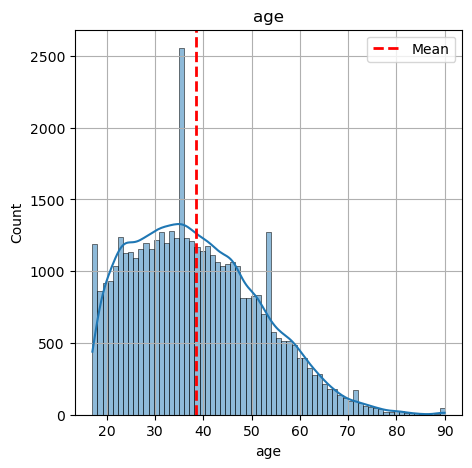

Min: 17
Max: 90
Mean: 38.547941267524656
Std: 13.217870219055524
Skewness: 0.5328158942555791
Kurtosis -0.15587445202596317


In [18]:
# View age histogram of the cleaned dataset
view_histogram(clean_adult_income, columns=['age'])

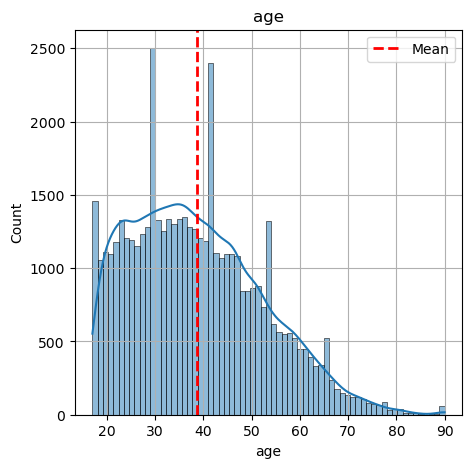

Min: 17
Max: 90
Mean: 38.64358543876172
Std: 13.71050993444322
Skewness: 0.5575803166133181
Kurtosis -0.18426874062387766


In [19]:
# View age histogram of the original dataset
view_histogram(adult_income, columns=['age'])

The comparison between the original and cleaned dataset shows insignificant statistical differences.

In [20]:
# Splitting the data by the mean value.
mean_age = clean_adult_income['age'].mean()
below_mean_age = clean_adult_income[clean_adult_income['age'] < mean_age]
above_mean_age = clean_adult_income[clean_adult_income['age'] > mean_age]

print('Number of people:')
print('Below mean age ->', len(below_mean_age))
print('Above mean age ->', len(above_mean_age))
print('Ratio ->', len(below_mean_age)/len(above_mean_age))

Number of people:
Below mean age -> 24238
Above mean age -> 20984
Ratio -> 1.1550705299275639


More (around 15.5%) of the working individuals are below the average age.

The distribution has a slight positive skewness, despite the fact that most of the workers are below the average age. This is due to the presence of a certain portion of workers who are in the age range of 60 to 90 years.

In [21]:
# These bins and labels will be used throughout the analysis below.
bins = [17, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['17-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


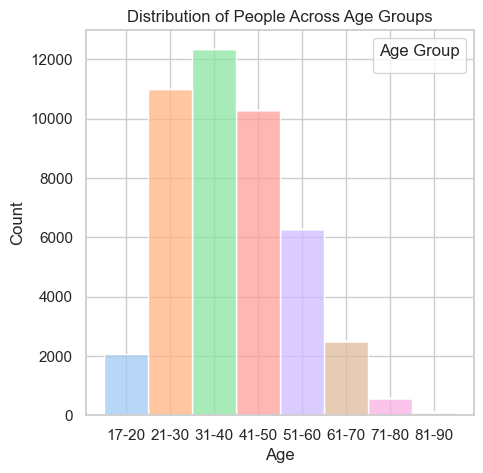

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.histplot(data=clean_adult_income, x=pd.cut(clean_adult_income['age'], bins=bins, labels=labels, right=False), hue=pd.cut(adult_income['age'], bins=bins, labels=labels, right=False), multiple="stack", palette="pastel")

plt.legend(title='Age Group')
plt.title('Distribution of People Across Age Groups')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

The majority of the working population is between 20 and 60 years old.

#### Age - Income analysis

In [23]:
ages_counts_income = create_group_dataframe(clean_adult_income, 'age', 'income', bins, labels)
ages_counts_income

,age,<=50K,>50K
0,17-20,2472,3
1,21-30,10331,961
2,31-40,8785,3506
3,41-50,6131,3859
4,51-60,3664,2169
5,61-70,1628,584
6,71-80,419,103
7,81-90,91,23


In [24]:
ages_counts_income.describe().T

,count,mean,std,min,25%,50%,75%,max
<=50K,8.0,4190.125,3843.504221,91.0,1325.75,3068.0,6794.50,10331.0
>50K,8.0,1401.000,1579.411916,3.0,83.00,772.5,2503.25,3859.0


In [25]:
ages_counts_income['<=50K'].sum(),ages_counts_income['>50K'].sum()

(33521, 11208)

In [26]:
round(ages_counts_income['<=50K'].sum()/len(clean_adult_income)*100, 2),  round(ages_counts_income['>50K'].sum()/len(clean_adult_income)*100, 2)

(74.13, 24.78)

Approximately three-quarters of people earn less or equal to 50,000.

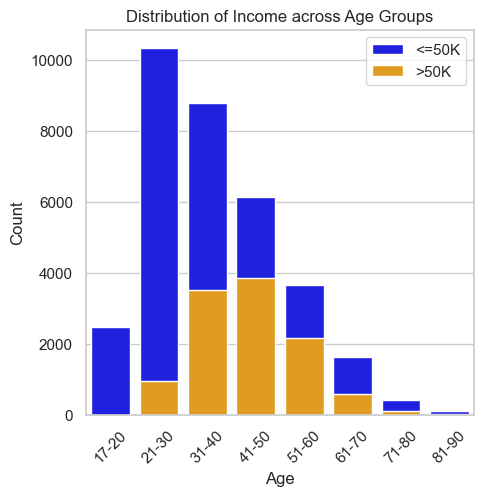

In [27]:
plt.figure(figsize=(5, 5))
sns.barplot(x='age', y='<=50K', data=ages_counts_income, color='blue', label='<=50K')

sns.barplot(x='age', y='>50K', data=ages_counts_income, color='orange', label='>50K')

plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Income across Age Groups')
plt.legend()
plt.show()

In [28]:
print('Percentage distribution of incomes by age group.')

print('Age', ' ' * 6, 'Total people count', ' ' * 6, '<=50K', ' ' * 6, '>50K')
for i in range(len(ages_counts_income.age)):
    
    below = ages_counts_income['<=50K'][i]
    above = ages_counts_income['>50K'][i]
    total_people = below + above
    age_group = ages_counts_income['age'][i]
    print(age_group,' ' * 5, total_people,' ' * 18,  round(below/total_people*100, 2),'%',' ' * 5,  round(above/total_people*100, 2), '%')

Percentage distribution of incomes by age group.
Age        Total people count        <=50K        >50K
17-20       2475                    99.88 %       0.12 %
21-30       11292                    91.49 %       8.51 %
31-40       12291                    71.48 %       28.52 %
41-50       9990                    61.37 %       38.63 %
51-60       5833                    62.82 %       37.18 %
61-70       2212                    73.6 %       26.4 %
71-80       522                    80.27 %       19.73 %
81-90       114                    79.82 %       20.18 %


As seen from the barchart and the percentage breakdown of incomes by age group, in all age groups, the majority of people earn less than or equal to 50,000. It is evident that the percentage of high income is lowest in the 17 to 30 age range and highest between the ages of 31 and 60. This makes sense - as individuals age, it is normal for their incomes to increase due to accumulated experience, on one hand, and their significant workforce capability, in other hand. This percentage remains relatively high - around 20 percent - even in advanced age (60 years and above), despite the drastic decrease in the number of working individuals in this age group after the age of 60. Additionally, it can be observed that the highest employment rate for individuals is between 21 and 40 years old, gradually declining afterward.

#### Age - Gender analysis

In [29]:
grouped_data = clean_adult_income.groupby('gender').agg({'age': ['count', 'mean']}).reset_index()
print(grouped_data.sort_values(by=('age','mean'), ascending=False))

   gender    age           
           count       mean
1    Male  30527  39.300423
0  Female  14695  36.984757


In [30]:
# Cleaned dataset male/female ratio
females, males = grouped_data.age.value_counts().index[0][0],grouped_data.age.value_counts().index[1][0]
ratio = females/(males + females)
print('Females ratio:',ratio)
print('Males ratio:', 1 - ratio)

Females ratio: 0.32495245676882933
Males ratio: 0.6750475432311707


In [31]:
# Original dataset male/female ratio
females, males = adult_income.gender.value_counts()[1],adult_income.gender.value_counts()[0]
ratio = females/(males + females)
print('Females ratio:',ratio)
print('Males ratio:', 1 - ratio)

Females ratio: 0.33151795585766347
Males ratio: 0.6684820441423365


The male-to-female ratio does not show a significant change after reducing the dataset by 7 percent.

Just over two-thirds of the workforce are men, with their average age slightly higher compared to that of women. Possible explanations include: the dataset's composition being primarily composed of interviews with men (relying on the traditional male role of working and earning money); later retirement age for men (Without having data that this is the prevailing retirement age condition. But the higher average age of working men supports such an assumption. In addition, since the majority of the data in this dataset is collected in the United States, they should have the greatest influence. On average, women in the United States retire earlier than men.); greater involvement of women in caregiving responsibilities for children during certain periods of their lives, etc.

In [32]:
ages_counts_gender = create_group_dataframe(clean_adult_income,'age', 'gender', bins, labels)
ages_counts_gender

,age,Male,Female
0,17-20,1282,1193
1,21-30,7078,4214
2,31-40,8695,3596
3,41-50,7112,2878
4,51-60,4189,1644
5,61-70,1507,705
6,71-80,337,185
7,81-90,79,35


In [33]:
ages_counts_gender.describe().T

,count,mean,std,min,25%,50%,75%,max
Male,8.0,3784.875,3448.840941,79.0,1045.75,2848.0,7086.5,8695.0
Female,8.0,1806.250,1582.495475,35.0,575.00,1418.5,3057.5,4214.0


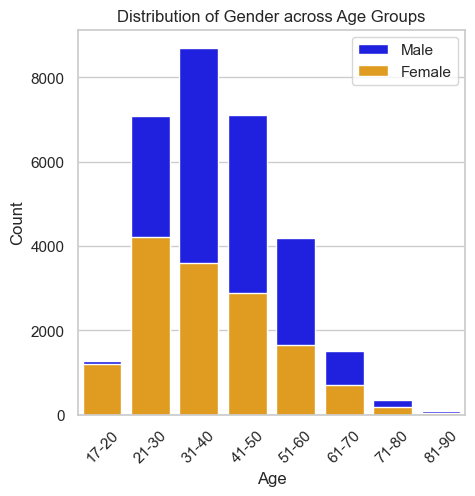

In [34]:
plt.figure(figsize=(5, 5))
sns.barplot(x='age', y='Male', data=ages_counts_gender, color='blue', label='Male')

sns.barplot(x='age', y='Female', data=ages_counts_gender, color='orange', label='Female')

plt.xticks(rotation=45)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Gender across Age Groups')
plt.legend()
plt.show()

Here, a clear trend is evident - in the working-age range of 21-60, the majority of the workforce is comprised of men. The working age largely coincides with the fertile age range for women, 17-50. It is likely that all the factors mentioned above, and many others for sure, have an impact on this result.

#### Age - Education analysis

In [35]:
ages_counts_education = create_group_dataframe(clean_adult_income,'age', 'education', bins, labels)
ages_counts_education

,age,11th,HS_grad,Assoc_acdm,Some_college,10th,Prof_school,7th_8th,Bachelors,Masters,5th_6th,Assoc_voc,9th,Doctorate,12th,1st_4th,Preschool
0,17-20,310,862,15,989,76,0,21,2,2,15,16,37,0,122,4,4
1,21-30,337,3684,419,2938,244,78,107,2208,294,100,538,145,28,124,31,17
2,31-40,302,4203,526,2436,256,230,130,2312,683,87,654,155,133,116,51,17
3,41-50,205,2995,363,2031,162,272,163,1884,920,103,467,103,191,65,54,12
4,51-60,148,2067,139,1043,211,121,189,800,451,86,204,130,126,59,47,12
5,61-70,65,758,40,360,99,58,138,296,133,37,64,58,49,27,23,7
6,71-80,16,169,2,82,21,19,58,52,23,16,15,14,17,6,9,3
7,81-90,4,33,3,17,4,7,13,16,8,2,1,2,0,1,3,0


In [36]:
# Combine and reduce columns
ages_counts_education['No_HS_grad'] = ages_counts_education[['Preschool', '1st_4th', '5th_6th', '7th_8th', '9th', '10th', '11th', '12th']].sum(axis=1)
ages_counts_education['Associate_degree'] = ages_counts_education[['Assoc_acdm', 'Assoc_voc']].sum(axis=1)
ages_counts_education['HS_grad'] = ages_counts_education[['Prof_school', 'HS_grad']].sum(axis=1)

ages_counts_education.drop(columns=['Preschool', '1st_4th', '5th_6th', '7th_8th', '9th', '10th', '11th', '12th','Assoc_acdm', 'Assoc_voc','Prof_school'], inplace=True)

ages_counts_education

,age,HS_grad,Some_college,Bachelors,Masters,Doctorate,No_HS_grad,Associate_degree
0,17-20,862,989,2,2,0,589,31
1,21-30,3762,2938,2208,294,28,1105,957
2,31-40,4433,2436,2312,683,133,1114,1180
3,41-50,3267,2031,1884,920,191,867,830
4,51-60,2188,1043,800,451,126,882,343
5,61-70,816,360,296,133,49,454,104
6,71-80,188,82,52,23,17,143,17
7,81-90,40,17,16,8,0,29,4


The following is a breakdown of educational degrees by age groups.

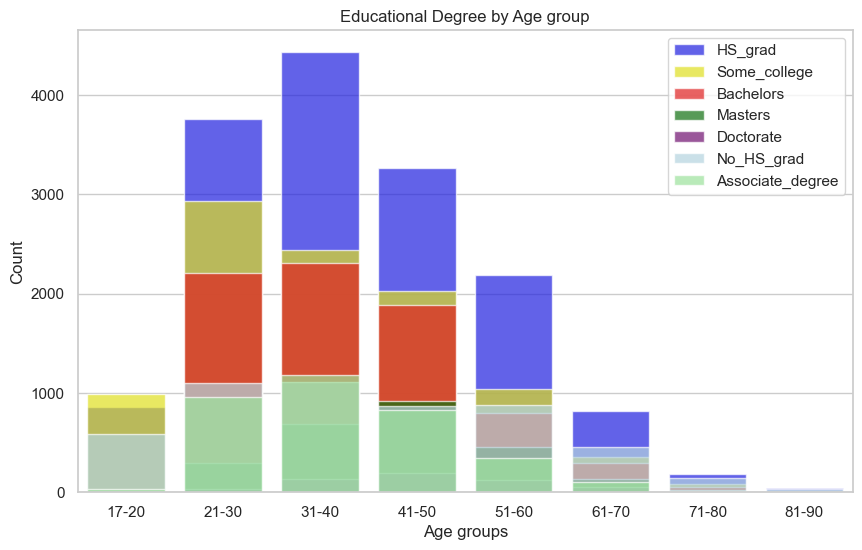

In [37]:
plt.figure(figsize=(10, 6))

colors = iter(['blue', 'yellow', 'red', 'green', 'purple', 'lightblue', 'lightgreen', 'grey'])

for degree in ages_counts_education.drop(columns=['age']).columns.unique():
    sns.barplot(x = 'age', y = ages_counts_education[degree], data=ages_counts_education, label = degree, color = next(colors), alpha = 0.7)
plt.legend()
plt.title('Educational Degree by Age group')
plt.xlabel('Age groups')
plt.ylabel('Count')
plt.show()

In [38]:
print_percentages(ages_counts_education, 'age')

Percentage Ratios by age
     age    HS_grad  Some_college  Bachelors   Masters  Doctorate  No_HS_grad  \
0  17-20  34.828283     39.959596   0.080808  0.080808   0.000000   23.797980   
1  21-30  33.315622     26.018420  19.553666  2.603613   0.247963    9.785689   
2  31-40  36.067041     19.819380  18.810512  5.556912   1.082093    9.063542   
3  41-50  32.702703     20.330330  18.858859  9.209209   1.911912    8.678679   
4  51-60  37.510715     17.881022  13.715069  7.731870   2.160123   15.120864   
5  61-70  36.889693     16.274864  13.381555  6.012658   2.215190   20.524412   
6  71-80  36.015326     15.708812   9.961686  4.406130   3.256705   27.394636   
7  81-90  35.087719     14.912281  14.035088  7.017544   0.000000   25.438596   

   Associate_degree  
0          1.252525  
1          8.475027  
2          9.600521  
3          8.308308  
4          5.880336  
5          4.701627  
6          3.256705  
7          3.508772  


Most people - slightly above 70% - have completed school, college, or hold a bachelor's degree. This indicates a good level of education among the working population, but it should be noted that, due to the largest share of interviewed citizens in the USA, this chart is largely influenced by the educational status of their population. People who have not completed high school education are twice as many as those who have completed a doctorate or master's degree. 

There is a clear trend indicating that the new generations are more inclined to pursue education. On the other hand, there is a distinct downward trend for those with incomplete secondary education towards the younger generation. Among the age groups over 51, the percentage is nearly double compared to those aged 21 to 51.

There is also a strong tendency for an increase in individuals who have completed a two-year college degree. The lower levels of education among older generations - above the age of 60 - may be partially explained by higher mortality rates in these age groups, but only to some extent. Mortality affects all individuals equally, and therefore, it cannot be expected to significantly influence the percentage distribution.

#### Age - Marital status analysis

In [39]:
clean_adult_income.marital_status.unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Separated',
       'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [40]:
ages_count_marital = create_group_dataframe(clean_adult_income, 'age', 'marital_status', bins, labels)
ages_count_marital

,age,Never_married,Married_civ_spouse,Widowed,Separated,Divorced,Married_spouse_absent,Married_AF_spouse
0,17-20,2360,72,0,13,17,10,3
1,21-30,7168,3009,19,276,678,126,16
2,31-40,2931,6623,76,502,1997,152,10
3,41-50,1084,5985,207,398,2159,155,2
4,51-60,389,3697,390,181,1101,74,1
5,61-70,121,1342,394,37,295,23,0
6,71-80,33,273,160,3,43,10,0
7,81-90,22,52,31,1,7,1,0


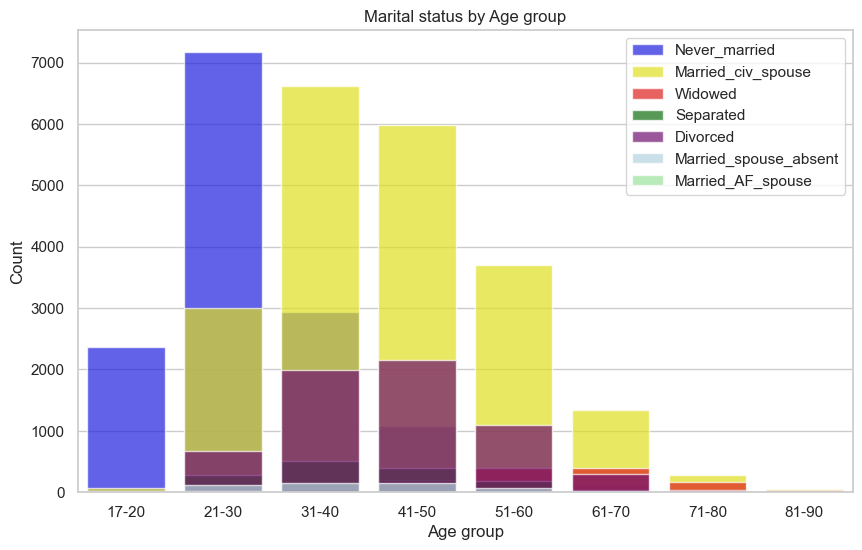

,age,Never_married,Married_civ_spouse,Widowed,Separated,Divorced,Married_spouse_absent,Married_AF_spouse
0,17-20,95.353535,2.909091,0.000000,0.525253,0.686869,0.404040,0.121212
1,21-30,63.478569,26.647184,0.168261,2.444208,6.004251,1.115834,0.141693
2,31-40,23.846717,53.884956,0.618339,4.084289,16.247661,1.236677,0.081360
3,41-50,10.850851,59.909910,2.072072,3.983984,21.611612,1.551552,0.020020
4,51-60,6.668953,63.380765,6.686096,3.103034,18.875364,1.268644,0.017144
5,61-70,5.470163,60.669078,17.811935,1.672694,13.336347,1.039783,0.000000
6,71-80,6.321839,52.298851,30.651341,0.574713,8.237548,1.915709,0.000000
7,81-90,19.298246,45.614035,27.192982,0.877193,6.140351,0.877193,0.000000


In [41]:
plt.figure(figsize=(10, 6))

colors = iter(['blue', 'yellow', 'red', 'green', 'purple', 'lightblue', 'lightgreen'])

for m_status in ages_count_marital.drop(columns=['age']).columns.unique():
    sns.barplot(x = 'age', y = ages_count_marital[m_status], data=ages_count_marital, label = m_status, color = next(colors), alpha = 0.7)
plt.legend()
plt.title('Marital status by Age group')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

total_people_age_group = ages_count_marital.iloc[:, 1:].sum(axis=1)
percentage_marital_by_group = ages_count_marital.iloc[:, 1:].div(total_people_age_group, axis=0) * 100
percentage_marital_by_group.insert(0, 'age', ages_count_marital.age)
percentage_marital_by_group

These data reveal interesting patterns. Understandably, the highest percentage of unmarried individuals is in the age range between 17 and 30 years. Since more than 90 percent of the respondents are residents of the USA, this statistic reflects the trend among young people there, which is likely valid for Western civilizations in general—prioritizing personal development, acquiring education, and pursuing career success over early marriage. As age progresses, this percentage shows a strong tendency to decrease—from 95% in the range up to 20 years old to 6.67% between 51 and 60 years old. Logically, the percentage of married individuals starts to significantly increase from the age of 21, peaking in the range of 31 to 40. This also affirms the trend that, after completing their education and somewhat concurrently with their professional development, people increasingly focus on starting a family.

In parallel with the increase in marriages, there is also an observed rise in divorces in the years after 21, with their peak occurring between 41 and 50 years old. There are at least two probable reasons—one being that in this age range, the couple's children have likely grown up and taken their own path, meaning one of the main reasons for entering and sustaining a marriage diminishes. The other reason is that at this age, individuals more frequently reflect on and reassess their lives, including their relationships with their marital partners.

The percentage of separated couples, i.e., those who are married but live separately, doesn't undergo significant changes and remains at low percentages around 3-4%. These individuals are likely unwilling to engage in the difficulties associated with divorce proceedings.

The percentage of widowed individuals sees a substantial increase only after the age of 51, reaching its highest values after 71 years. This coincides with the average life expectancy.

#### Age - Occupation analysis

In [42]:
age_count_occupation = create_group_dataframe(clean_adult_income, 'age', 'occupation', bins,labels)
age_count_occupation

,age,Machine_op_inspct,Farming_fishing,Protective_serv,Other_service,Prof_specialty,Craft_repair,Adm_clerical,Exec_managerial,Tech_support,Sales,Priv_house_serv,Transport_moving,Handlers_cleaners,Armed_Forces
0,17-20,142,88,31,658,73,152,381,52,39,492,15,73,279,0
1,21-30,814,300,266,1360,1312,1379,1699,1002,437,1417,55,472,770,9
2,31-40,884,379,286,1072,1738,1996,1343,1776,433,1247,27,660,448,2
3,41-50,641,288,210,717,1700,1411,1082,1726,308,1053,36,540,276,2
4,51-60,357,205,109,493,791,819,662,985,153,678,35,406,139,1
5,61-70,113,136,47,232,294,213,260,343,44,297,33,139,61,0
6,71-80,12,55,21,81,67,26,62,73,4,72,19,17,13,0
7,81-90,4,12,2,11,17,6,12,24,1,16,2,4,3,0


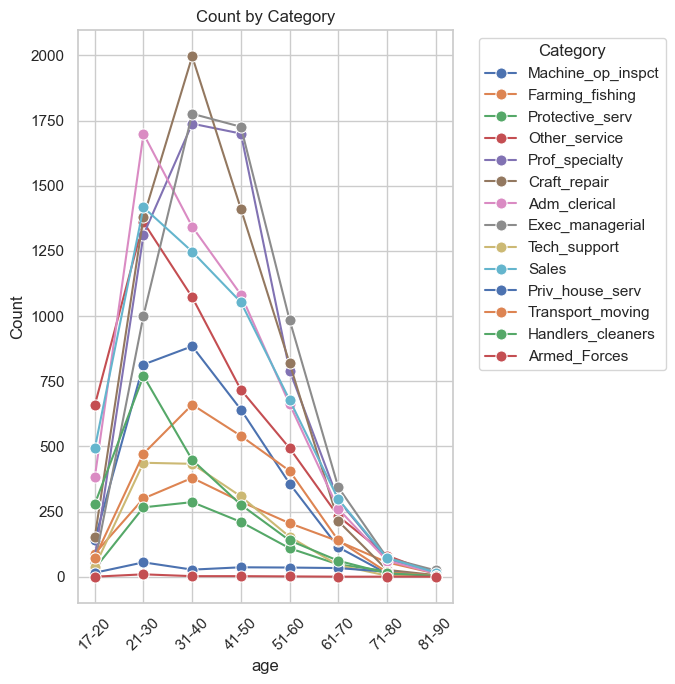

In [43]:
create_scatterplot(age_count_occupation, 'age')

In [44]:
count_workspace = age_count_occupation.describe().T
count_workspace

,count,mean,std,min,25%,50%,75%,max
Machine_op_inspct,8.0,370.875,361.561865,4.0,87.75,249.5,684.25,884.0
Farming_fishing,8.0,182.875,131.188455,12.0,79.75,170.5,291.00,379.0
Protective_serv,8.0,121.500,115.912529,2.0,28.50,78.0,224.00,286.0
Other_service,8.0,578.000,474.600584,11.0,194.25,575.5,805.75,1360.0
Prof_specialty,8.0,749.000,743.178886,17.0,71.50,542.5,1409.00,1738.0
Craft_repair,8.0,750.250,766.580860,6.0,120.50,516.0,1387.00,1996.0
Adm_clerical,8.0,687.625,624.881917,12.0,210.50,521.5,1147.25,1699.0
Exec_managerial,8.0,747.625,733.114089,24.0,67.75,664.0,1183.00,1776.0
Tech_support,8.0,177.375,188.418180,1.0,30.25,98.5,339.25,437.0
Sales,8.0,659.000,533.566973,16.0,240.75,585.0,1101.50,1417.0


In [45]:
max_values = count_workspace['max'].sort_values(ascending=False)
max_values.head()

Craft_repair       1996.0
Exec_managerial    1776.0
Prof_specialty     1738.0
Adm_clerical       1699.0
Sales              1417.0
Name: max, dtype: float64

Obviously, most people are employed in the age range from 21 to 60, even up to the age of 70. Among the most occupied sectors are those requiring higher levels of qualification, such as sales, administrative positions, machine and equipment repair and control, specialized fields like medicine, law, engineering, and others. It is noticeable that sectors related to production are missing. This may reflect a certain bias in the data collection process.

In [46]:
clean_adult_income.relationship.unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [47]:
age_count_relationship = create_group_dataframe(clean_adult_income, 'age', 'relationship', bins, labels)
age_count_relationship

,age,Own_child,Husband,Not_in_family,Unmarried,Wife,Other_relative
0,17-20,1744,43,426,72,14,176
1,21-30,3175,2437,3774,923,437,546
2,31-40,868,5828,3091,1539,723,242
3,41-50,290,5400,2217,1386,543,154
4,51-60,87,3384,1318,630,287,127
5,61-70,13,1264,625,178,73,59
6,71-80,1,260,187,46,11,17
7,81-90,8,49,45,8,3,1


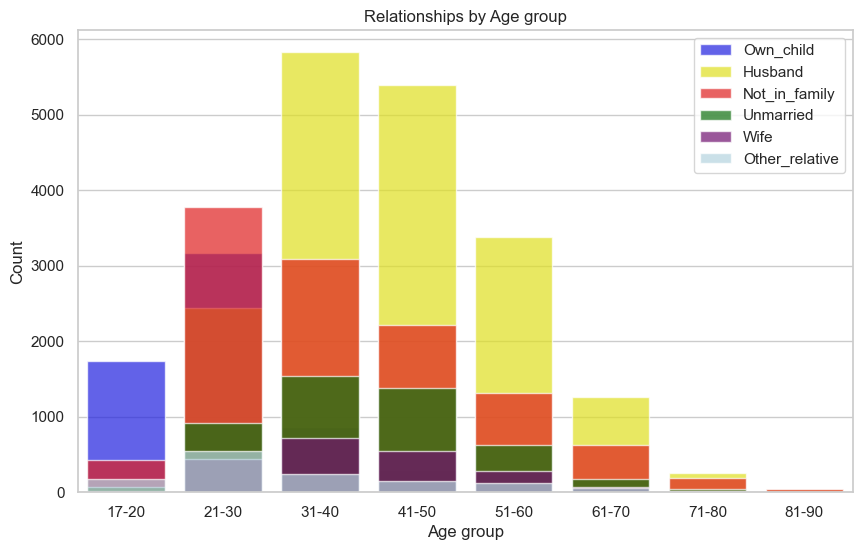

In [48]:
plt.figure(figsize=(10, 6))

colors = iter(['blue', 'yellow', 'red', 'green', 'purple', 'lightblue', 'lightgreen'])

for m_status in age_count_relationship.drop(columns=['age']).columns.unique():
    sns.barplot(x = 'age', y = age_count_relationship[m_status], data=ages_count_marital, label = m_status, color = next(colors), alpha = 0.7)
plt.legend()
plt.title('Relationships by Age group')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.show()

In [49]:
print_percentages(age_count_relationship, 'age')

Percentage Ratios by age
     age  Own_child    Husband  Not_in_family  Unmarried      Wife  \
0  17-20  70.464646   1.737374      17.212121   2.909091  0.565657   
1  21-30  28.117251  21.581651      33.421892   8.173928  3.869996   
2  31-40   7.062078  47.416809      25.148483  12.521357  5.882353   
3  41-50   2.902903  54.054054      22.192192  13.873874  5.435435   
4  51-60   1.491514  58.014744      22.595577  10.800617  4.920281   
5  61-70   0.587703  57.142857      28.254973   8.047016  3.300181   
6  71-80   0.191571  49.808429      35.823755   8.812261  2.107280   
7  81-90   7.017544  42.982456      39.473684   7.017544  2.631579   

   Other_relative  
0        7.111111  
1        4.835282  
2        1.968920  
3        1.541542  
4        2.177267  
5        2.667269  
6        3.256705  
7        0.877193  


In [50]:
age_count_relationship.describe().T

,count,mean,std,min,25%,50%,75%,max
Own_child,8.0,773.250,1145.435881,1.0,11.75,188.5,1087.00,3175.0
Husband,8.0,2333.125,2349.400436,43.0,207.25,1850.5,3888.00,5828.0
Not_in_family,8.0,1460.375,1414.067278,45.0,366.25,971.5,2435.50,3774.0
Unmarried,8.0,597.750,623.235051,8.0,65.50,404.0,1038.75,1539.0
Wife,8.0,261.375,280.315097,3.0,13.25,180.0,463.50,723.0
Other_relative,8.0,165.250,174.360669,1.0,48.50,140.5,192.50,546.0


Interesting findings. The majority of working individuals fall into the spouse category. This is because men constitute the larger portion of the interviewed population, as seen in the above analysis. Following are the unmarried individuals, with, for the individual age groups (those above 21 years old), being roughly half compared to the spouses (both married husbands and wives). The next largest group is the Own Child category, with its highest values in the range up to 20 years old and also comprising almost one-third of the range 21-30. There is a possibility that this distribution reflects a decline in birth rates in the USA over the past decades [https://www.macrotrends.net/countries/USA/united-states/birth-rate].

### Workclass

In [51]:
clean_adult_income.workclass.unique()

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

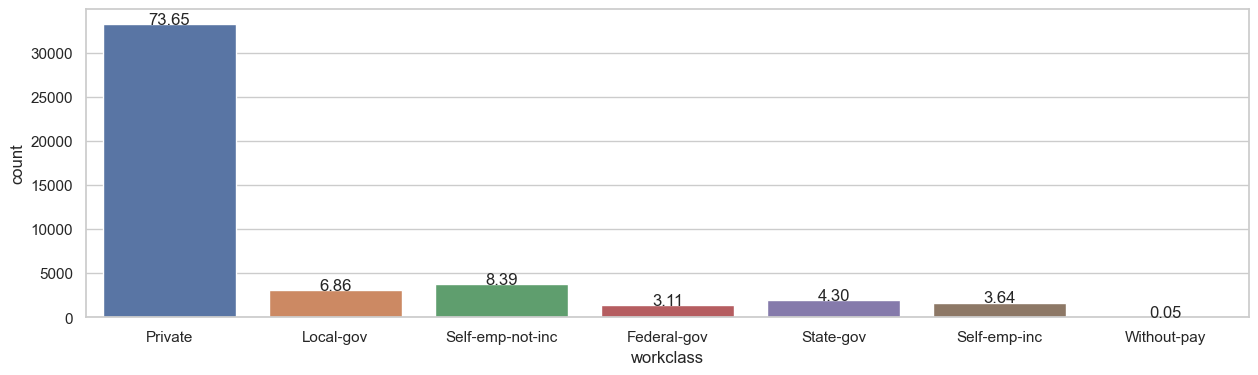

In [52]:
# Cleaned dataset workclass feature
show_countplot(clean_adult_income, 'workclass')

Approximately three-quarters of the employed individuals are engaged in the private sector.

In [53]:
print(clean_adult_income.workclass.value_counts().sort_values(ascending=False))

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64


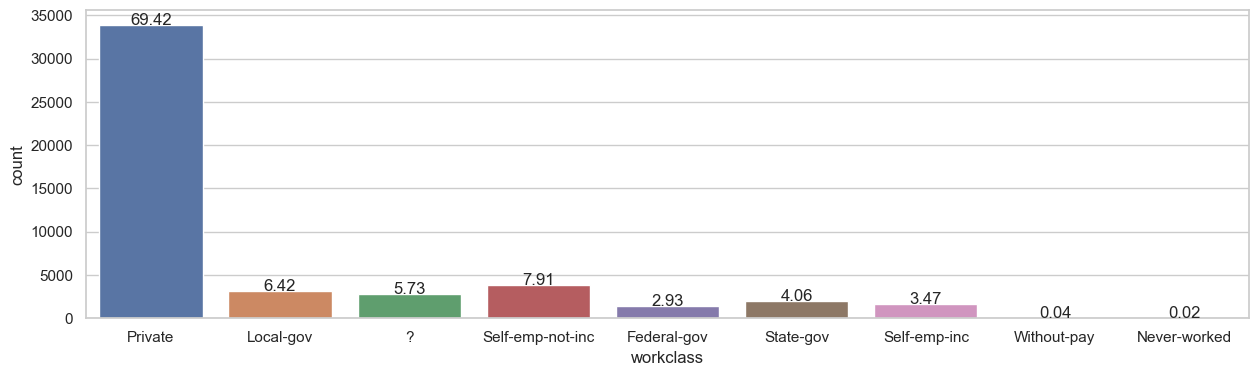

In [54]:
# Original dataset workclass feature.
show_countplot(adult_income, 'workclass')

In [55]:
 adult_income.workclass.value_counts().sort_values(ascending=False)

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


We can see that for this feature, the removal of 'NaN' values has had an impact - the percentages are elevated compared to the original dataset, and also one of the categories, 'Never-worked', is entirely missing. However, the ranking by size remains the same.

#### Workclass - Income analysis

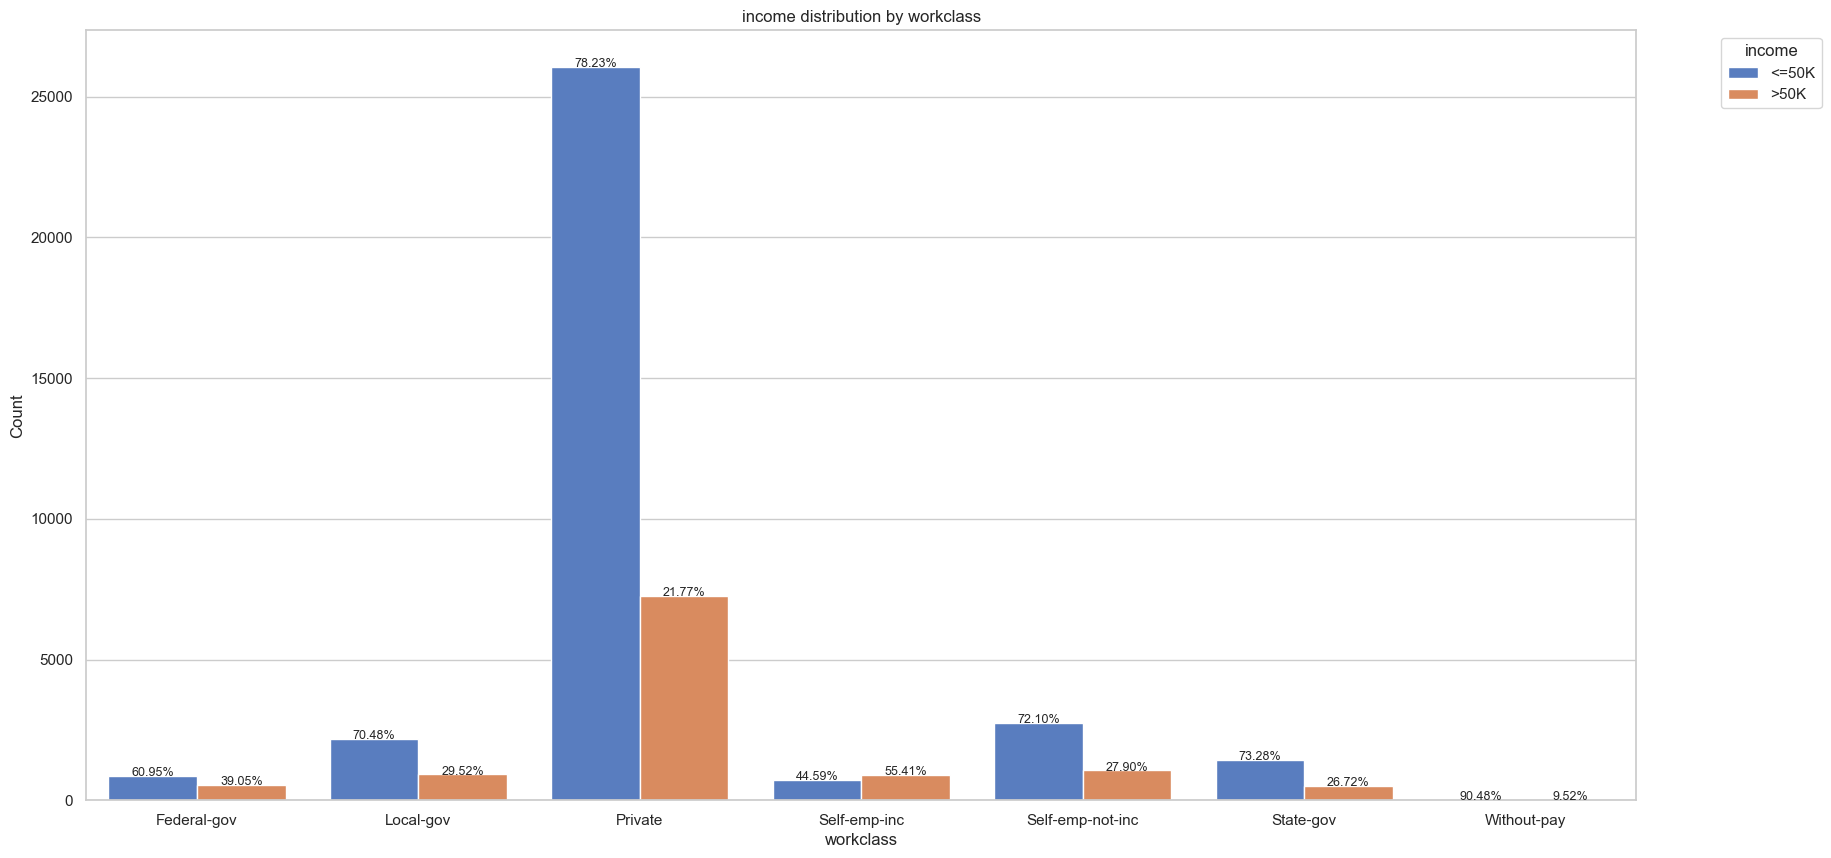

In [56]:
show_cat_features_barplot(clean_adult_income, 'workclass', 'income')

As seen, all workclass categories earn below 50K annually, constituting the income for slightly over 70 percent of individuals in each of them. Since over 90% of the data is collected in the USA, we can state that this represents the overall income situation for the country in the years around 1996. The only exception is the category of self-employed individuals in the business sector—just over half of them, 55.41%, earn more than 50K. We can conclude that, overall, about thirty percent of the employed individuals in the states, across almost all work classes, have high incomes.

#### Workclass - Hours per week analysis

In [57]:
bins = [1,20, 40, 60, 80,100]
labels = ['1-20', '21-40', '41-60', '61-80', '81-100']

In [58]:
workclass_count_hour = create_group_dataframe(clean_adult_income,  'hours_per_week', 'workclass', bins, labels)

In [59]:
workclass_count_hour

,hours_per_week,Private,Local_gov,Self_emp_not_inc,Federal_gov,State_gov,Self_emp_inc,Without_pay
0,1-20,2658,191,382,53,228,71,7
1,21-40,21258,2070,1592,1048,1311,556,8
2,41-60,8546,749,1427,279,348,834,5
3,61-80,689,77,301,23,50,152,1
4,81-100,148,13,91,3,8,33,0


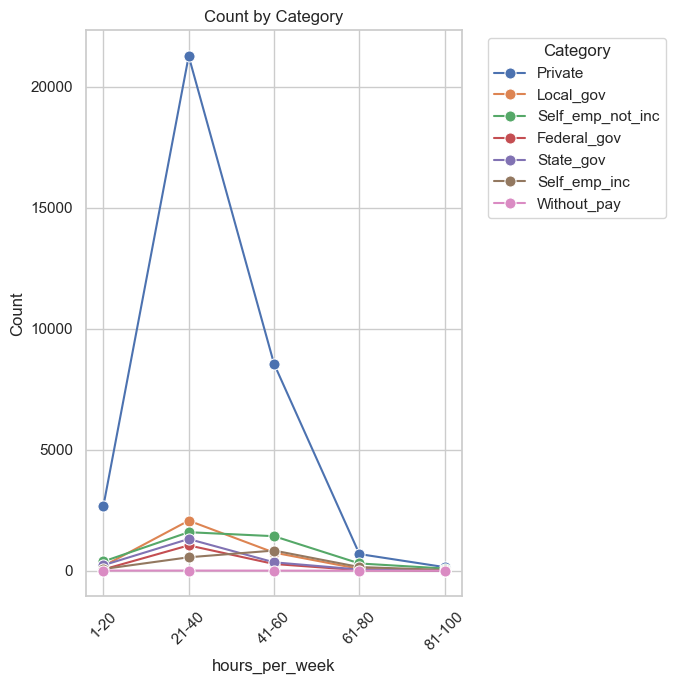

In [60]:
create_scatterplot(workclass_count_hour, 'hours_per_week')

In [61]:
print('Hours', ' ', 'Count')
clean_adult_income.hours_per_week.value_counts().sort_values(ascending=False).head()

Hours   Count


40    21358
50     4094
45     2602
60     2085
35     1776
Name: hours_per_week, dtype: int64

The majority of people work between 21 and 40 hours per week in almost all sectors. Similar to the previous graph, self-employed individuals in the business sector are an exception, with most working between 41 and 60 hours, i.e., more than eight hours a day. This is expected as their success depends on the amount of work they personally undertake. It is also evident that in the remaining hourly categories, the private business sector dominates, accounting for a significant share between 50% and 76%. The explanation remains the same – private businesses tend to demand a lot of work from their employees. Conversely, in the public sector - **Local_gov**, **Federal_gov** and **State_gov** -  a very small percentage of people work more than eight hours per week.

#### Workclass - Race Analysis

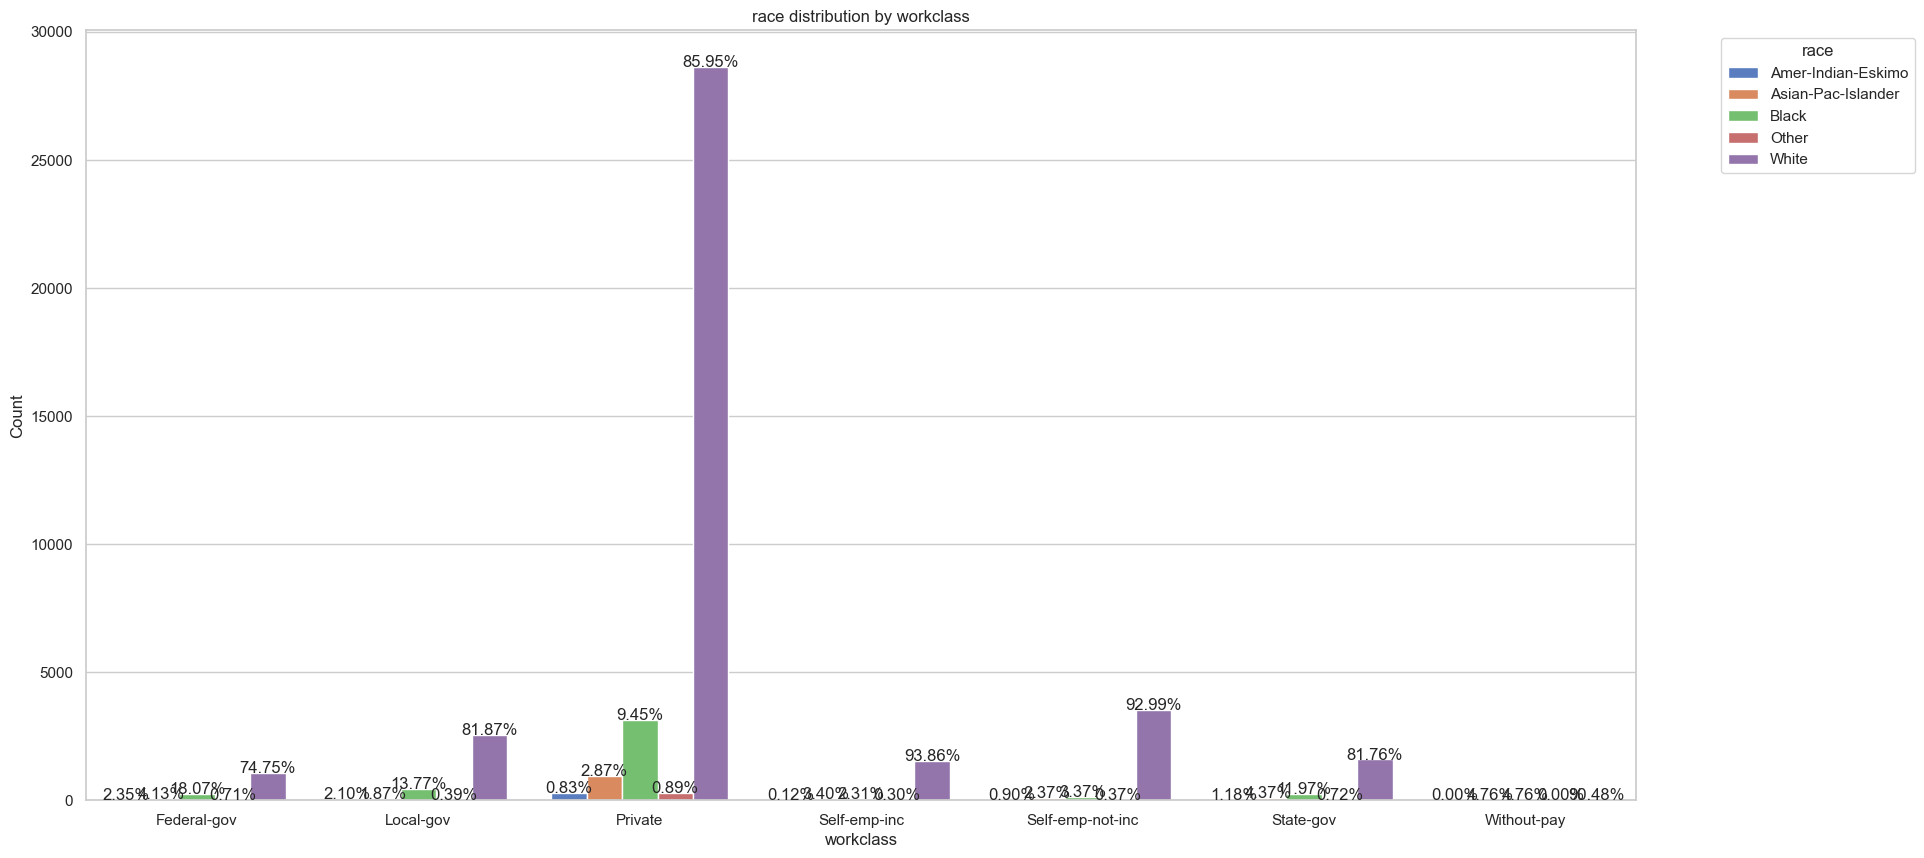

In [62]:
show_cat_features_barplot(clean_adult_income, 'workclass', 'race', figsize= (20, 10), fontsize=12)

As seen, over 80 percent of the workers in all sectors belong to the white race. This is a quite unrealistic result, suggesting that people from other races don't work at all. However, considering that over 90 percent of the respondents are from one country, there may be a certain **bias** here. Let's examine the distribution of workers based on race.

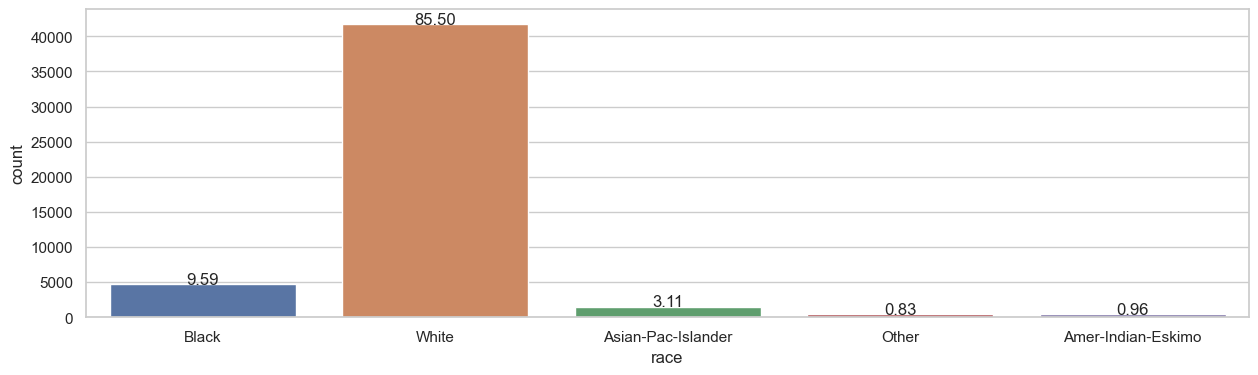

In [63]:
show_countplot(adult_income, 'race')

As expected, the majority of the interviewees are of the white race, which also explains the above distribution.

#### Workclass - Gender Analysis

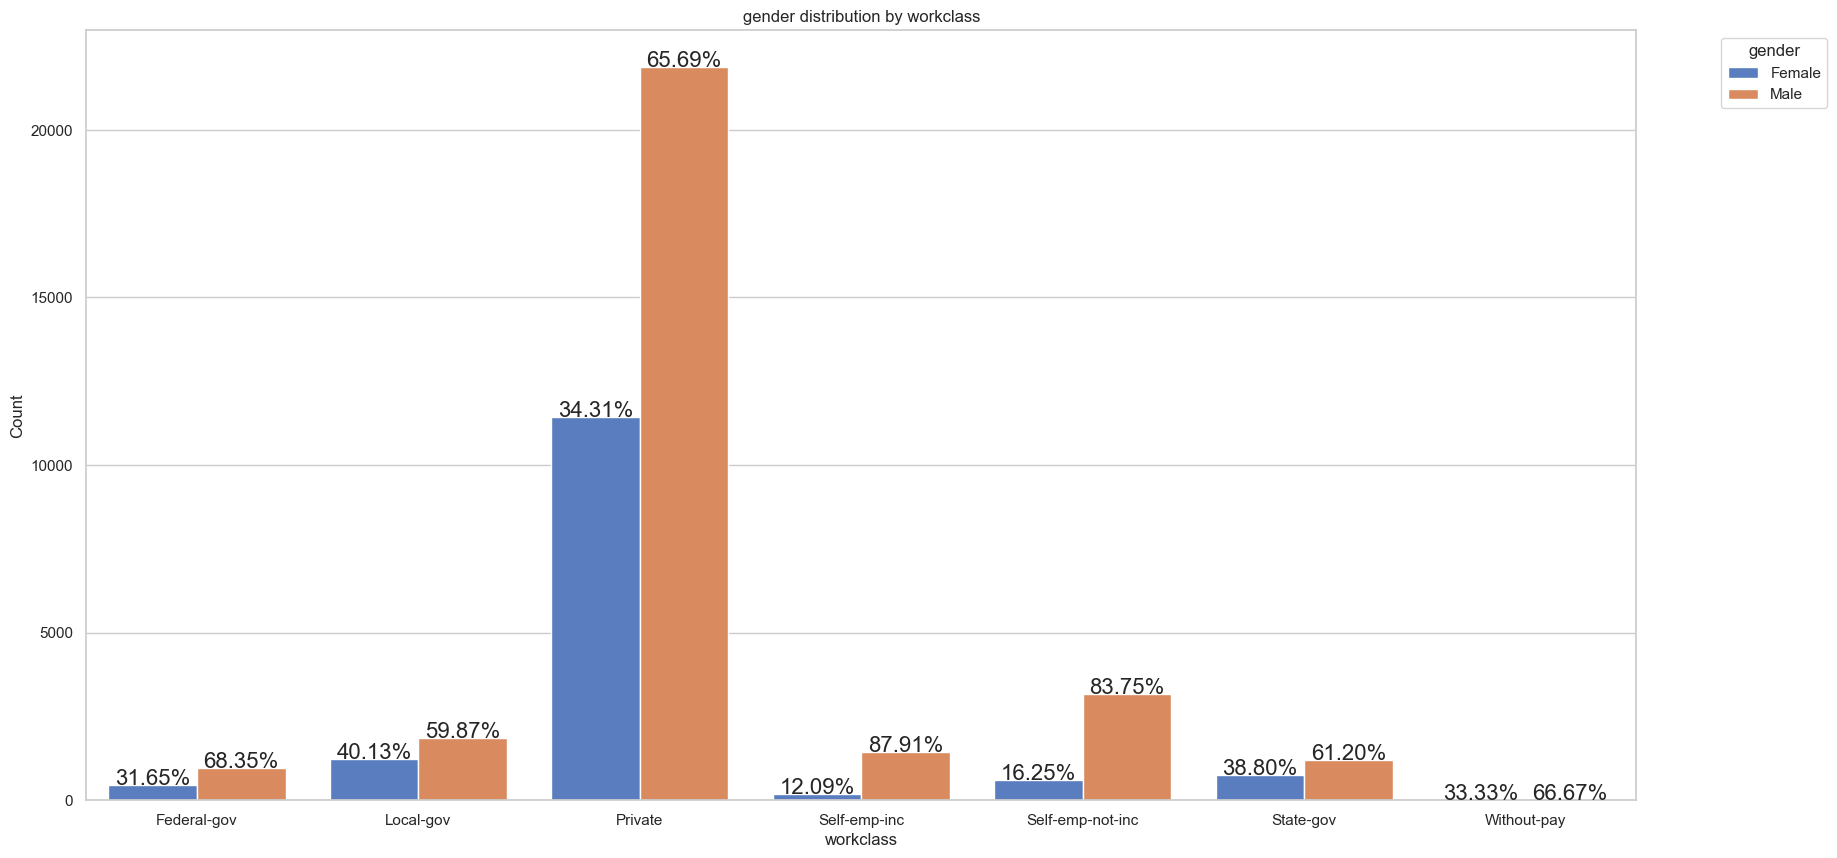

In [64]:
show_cat_features_barplot(clean_adult_income, 'workclass', 'gender', fontsize=16)

Here, it is interesting to point out and interpret the **differences** in percentages between the two genders. Men dominate as a percentage in all sectors, which is not surprising, as they constitute the larger part of the overall workforce. This influences the distribution across age groups, as shown above. On the graph, the largest difference in percentages between the two genders—more than 60% in both cases—is observed in the self-employed category. The differences are much smaller in the public sector, ranging between 20% and 35%. A possible explanation is that, on one hand, in self-employed sectors, the working hours are usually more than eight hours per week, as seen in the analysis [above](#Workclass---Hours-per-week-analysis). On the other hand, these are precisely the sectors where the level of risk is much higher.

#### Workclass - Gender Analysis

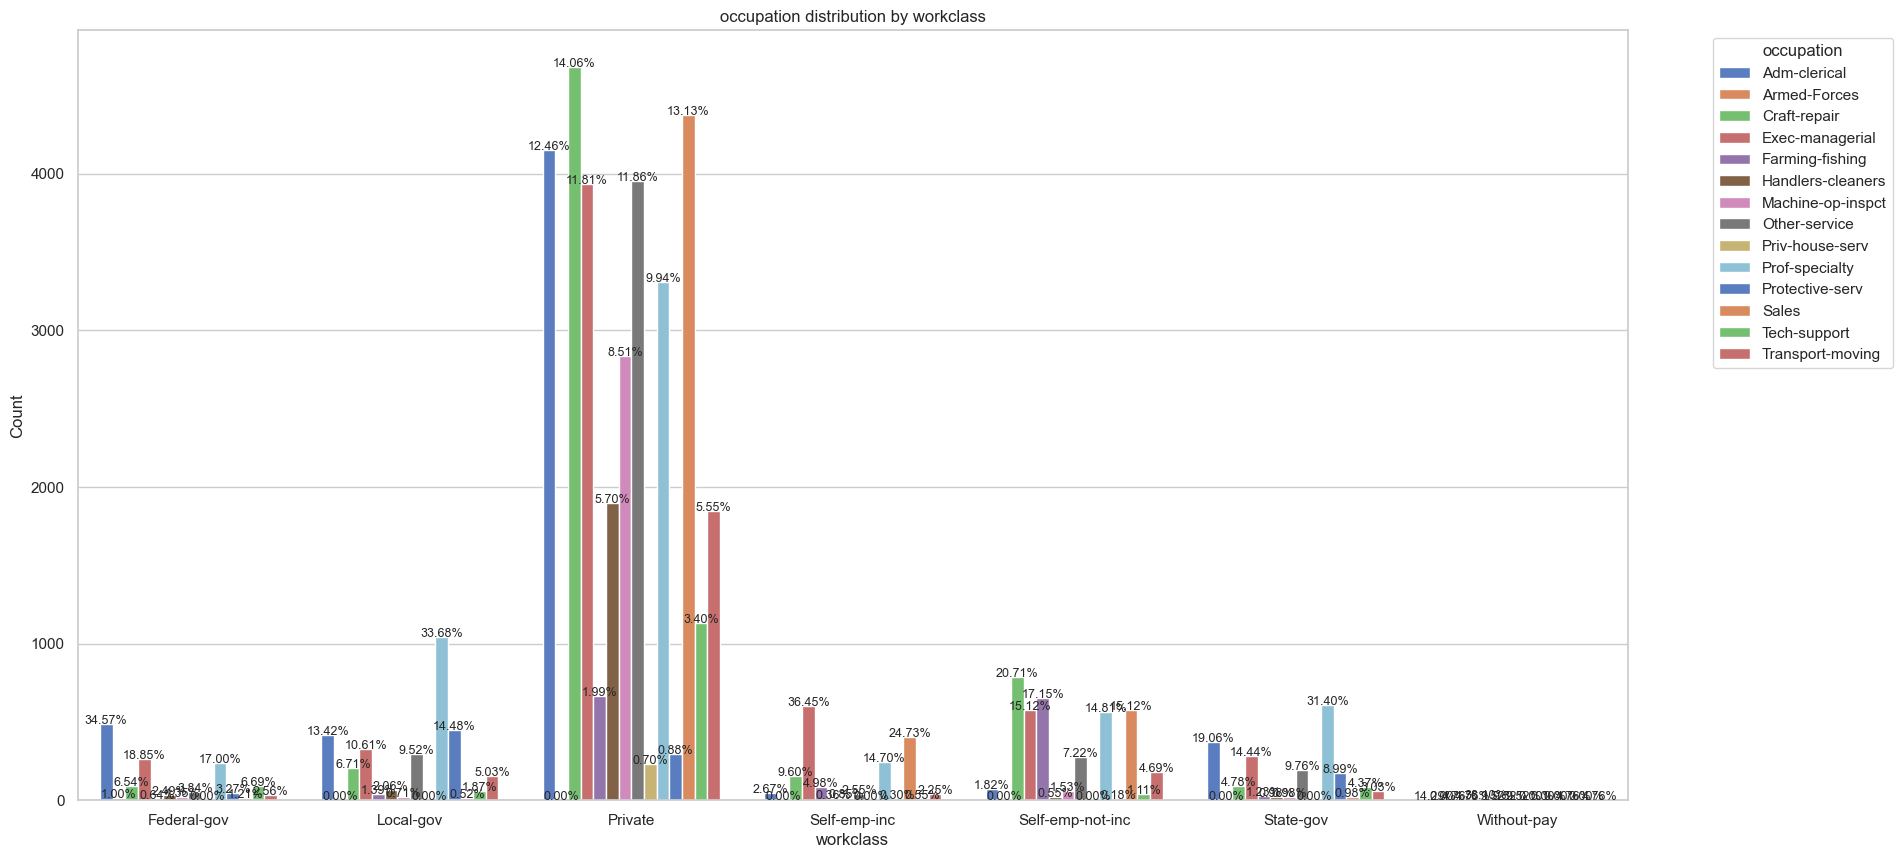

In [65]:
show_cat_features_barplot(clean_adult_income, 'workclass', 'occupation', figsize=(10,10), fontsize=9)

Nothing surprising. The private sector is the most employed, with professions that participate the least being **Armed-forces**, **Farming-fishing**, **Protective services** and **Private house sevices**. In the self-employed sector, trades dominate, such as **Craft repair**, **Farming-fishing**, **Handlers cleaning** and so on. The percentage of people working in their field of expertise is generally moderate to high, and in some places - like **Local government** and **State government** it is the highest.

### Education 

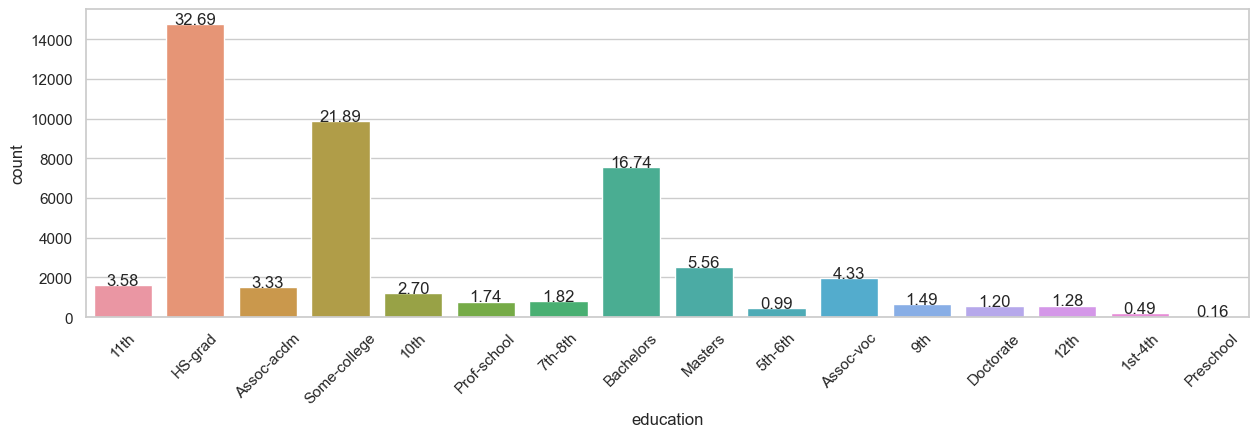

In [66]:
show_countplot(clean_adult_income, 'education', labels_rotation = 45)

Close to 70% of the workforce has 'good' education - completed high school, college or a bachelor's degree.

#### Education - Income analysis

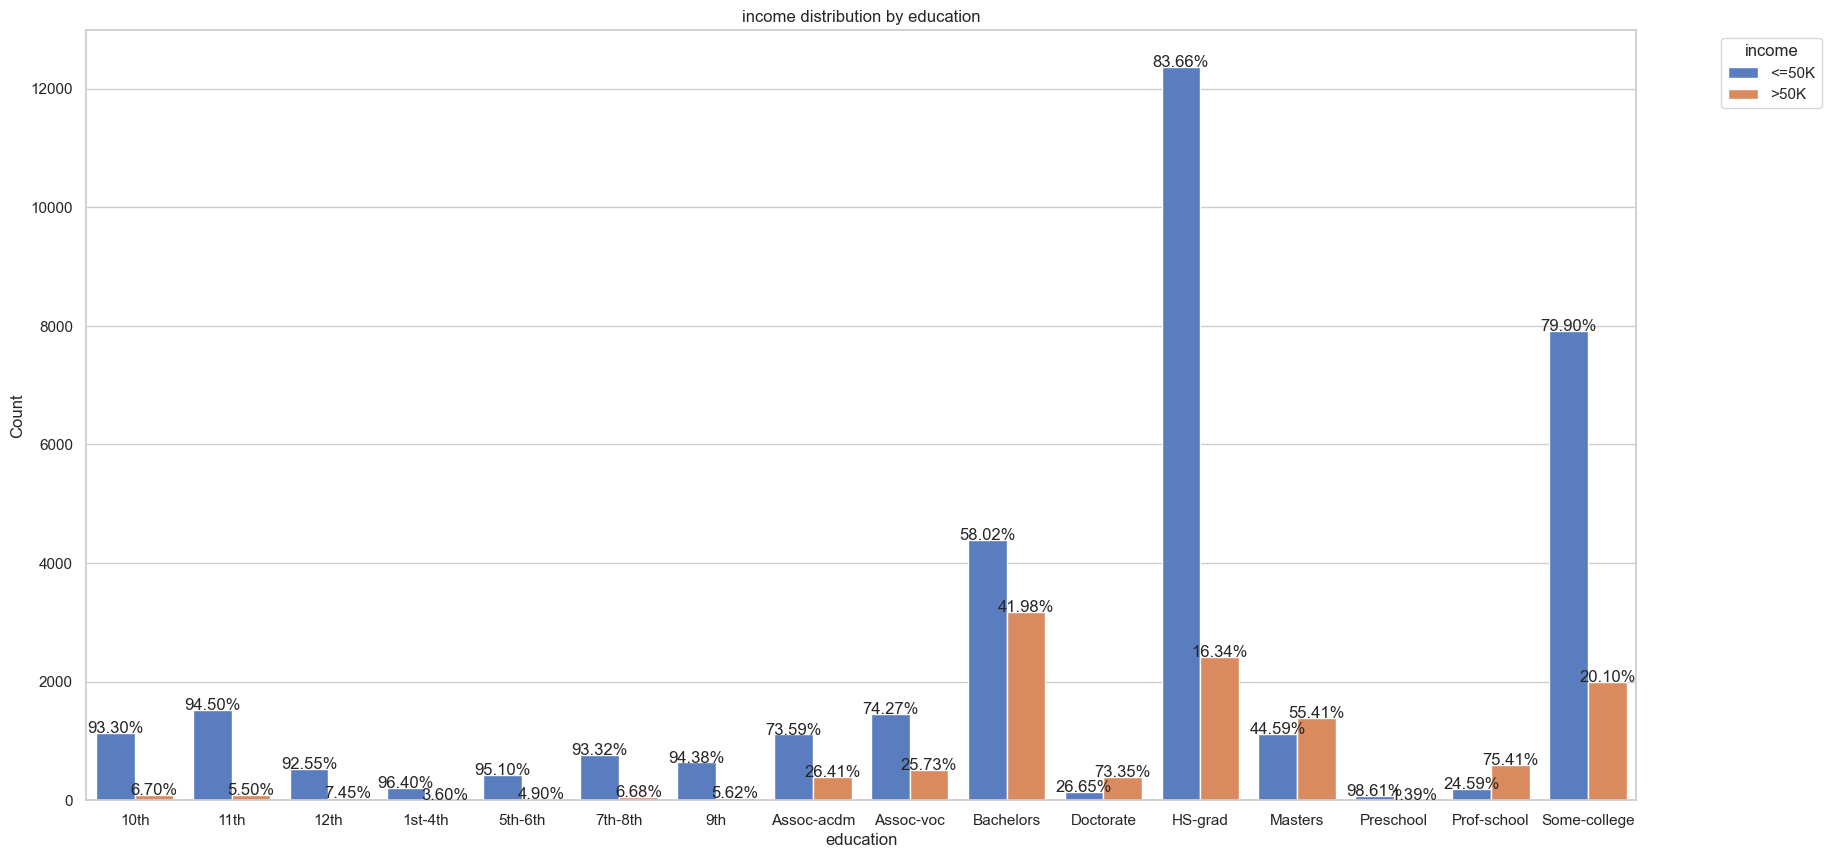

In [67]:
show_cat_features_barplot(clean_adult_income, 'education', 'income', figsize= (20, 10), fontsize=12)

Expectedly, in all education categories from 1st grade to college graduates, people with income below or equal to 50K predominate. Those with higher degrees - Ph.D. holders, master's degrees, as well as those who completed professional high schools, predominantly earn more than 50K, with the ratio favoring higher income being three-quarters for Ph.D. holders and those who completed professional high schools. This is normal - higher qualifications imply higher income.

#### Education - Marital status analysis

In [68]:
education_marital = clean_adult_income[['education', 'marital_status']]
education_marital

,education,marital_status
0,11th,Never-married
1,HS-grad,Married-civ-spouse
2,Assoc-acdm,Married-civ-spouse
3,Some-college,Married-civ-spouse
5,10th,Never-married
...,...,...
48837,Assoc-acdm,Married-civ-spouse
48838,HS-grad,Married-civ-spouse
48839,HS-grad,Widowed
48840,HS-grad,Never-married


In [69]:
# Grouping categories in the education column
education_mapping = {
    '1st-4th': 'No_HS_Grad',
    '5th-6th': 'No_HS_Grad',
    '7th-8th': 'No_HS_Grad',
    '9th': 'No_HS_Grad',
    '10th': 'No_HS_Grad',
    '11th': 'No_HS_Grad',
    '12th': 'No_HS_Grad',
    'Preschool': 'No_HS_Grad',
    'Assoc-voc': 'Associate_degree',
    'Assoc-acdm': 'Associate_degree'
}
education_marital = education_marital.copy()
education_marital['education'] = education_marital['education'].replace(education_mapping)
education_marital

,education,marital_status
0,No_HS_Grad,Never-married
1,HS-grad,Married-civ-spouse
2,Associate_degree,Married-civ-spouse
3,Some-college,Married-civ-spouse
5,No_HS_Grad,Never-married
...,...,...
48837,Associate_degree,Married-civ-spouse
48838,HS-grad,Married-civ-spouse
48839,HS-grad,Widowed
48840,HS-grad,Never-married


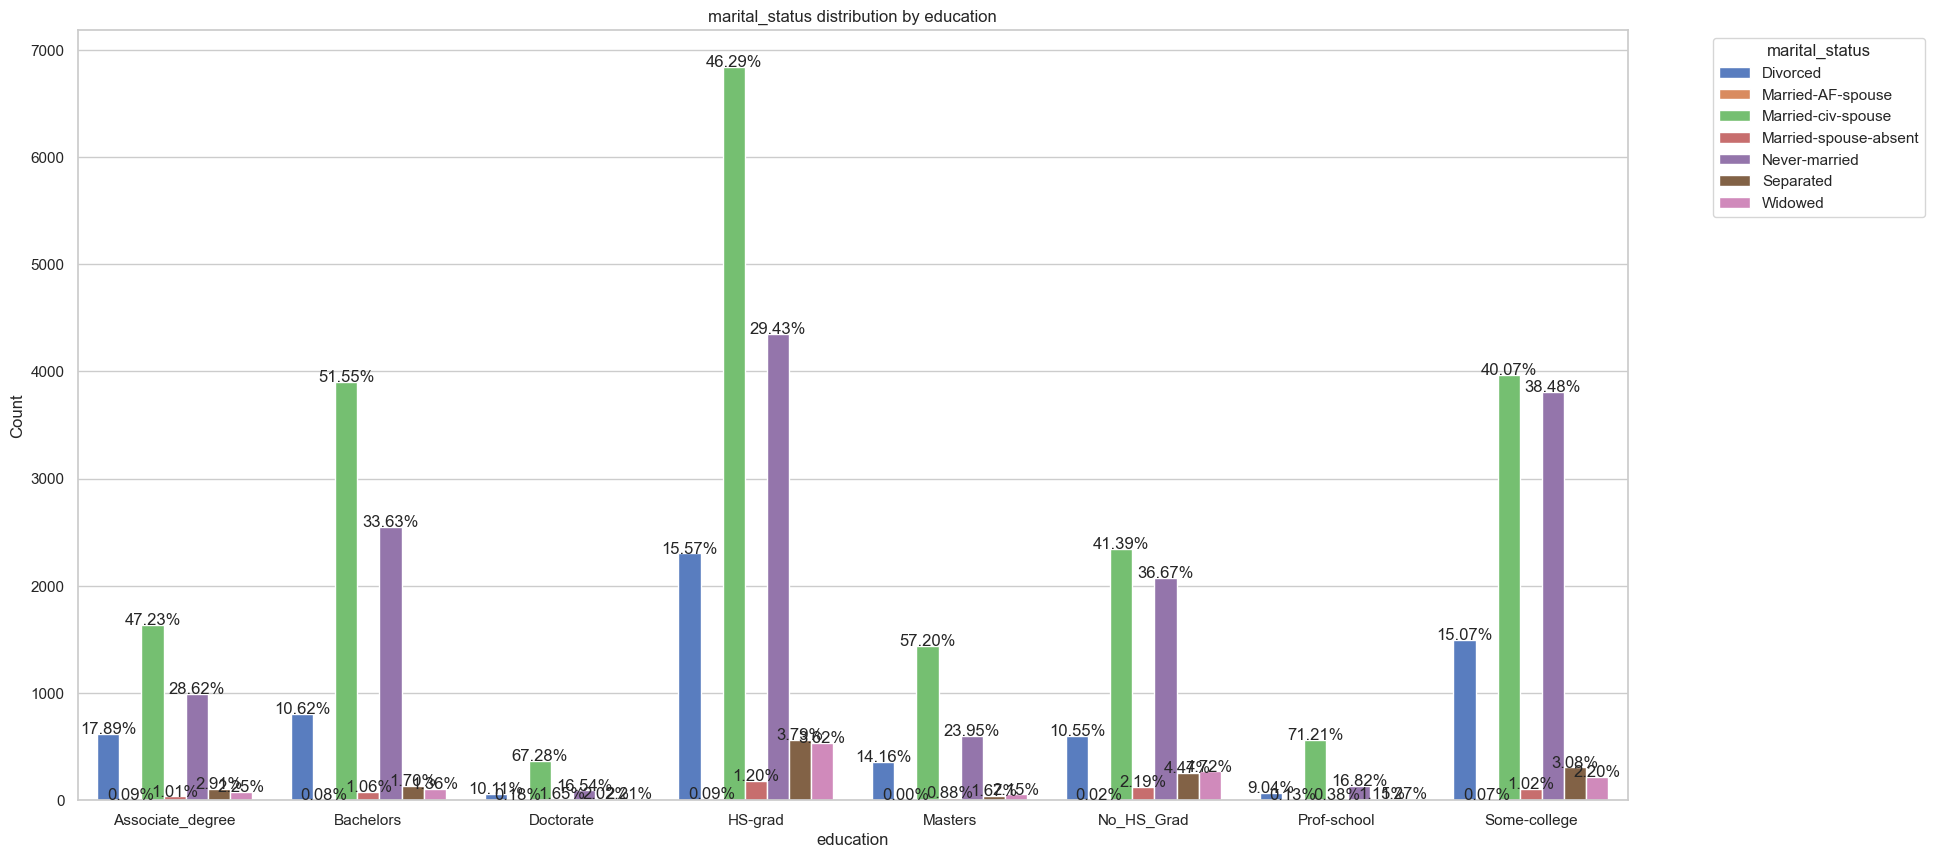

In [70]:
show_cat_features_barplot(education_marital, 'education', 'marital_status', figsize= (20, 10), fontsize=12)

In all educational levels, the majority of individuals are married, followed by those who have not been married. The percentage of divorced individuals is around 12% on average.

## Modeling

### Encoding 

In [71]:
clean_adult_without_income = pd.get_dummies(clean_adult_income.drop(columns=['income']), drop_first=True)
clean_adult_without_income

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,25,226802,7,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,12,0,0,38,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,40,154374,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,58,151910,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,22,201490,9,0,0,20,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [72]:
clean_adult_without_income['income'] = clean_adult_income.income

In [73]:
label_encoder = LabelEncoder()
clean_adult_without_income.income = label_encoder.fit_transform(clean_adult_without_income.income)
clean_adult_without_income.income

0        0
1        0
2        1
3        1
5        0
        ..
48837    0
48838    1
48839    0
48840    0
48841    1
Name: income, Length: 45222, dtype: int32

As seen, there is no feature that has a correlation with the target variable.

### Splitting the dataset for training and testing

In [74]:
X = clean_adult_without_income.drop(columns = ['income'])
y = clean_adult_without_income.income

In [75]:
X_train, X_test,y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [76]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33916, 96), (33916,), (11306, 96), (11306,))

### Scaling the data

In [77]:
scaler = StandardScaler()

In [78]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic regression

In [79]:
regression = LogisticRegression(random_state=1)

In [80]:
regression.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [81]:
regression.score(X_train_scaled, y_train)

0.8497759169713409

In [82]:
regression.score(X_test_scaled, y_test)

0.8470723509640898

In [83]:
sorted_feature_importances = sorted(list(zip(scaler.feature_names_in_, regression.coef_[0])), key=lambda x: x[1], reverse=True)[:10]
sorted_feature_importances

[('capital_gain', 2.3167687141576376),
 ('marital_status_Married-civ-spouse', 1.0931143790699356),
 ('educational_num', 0.5698602795205797),
 ('gender_Male', 0.36249582363042704),
 ('hours_per_week', 0.3411206134861199),
 ('age', 0.3248948782838596),
 ('occupation_Exec-managerial', 0.2892392175159451),
 ('capital_loss', 0.26136812397023224),
 ('relationship_Wife', 0.23877371653875168),
 ('occupation_Prof-specialty', 0.18952333845656993)]

In [84]:
prediction = regression.predict(X_test)
prediction

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1])

In [85]:
pd.Series(prediction).value_counts()

1    11306
dtype: int64

In [86]:
y_test.value_counts()

0    8504
1    2802
Name: income, dtype: int64

In [87]:
print(classification_report(y_test, prediction)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8504
           1       0.25      1.00      0.40      2802

    accuracy                           0.25     11306
   macro avg       0.12      0.50      0.20     11306
weighted avg       0.06      0.25      0.10     11306



C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression does not perform well. With **precision = 0.25** and **recall = 1**, this model aims to maximize recall, i.e., to identify all real positive cases, but the accuracy is low due to the large number of false positives. This is a common trend when there is an imbalance in the number of examples between classes.

### Decission Tree

In [88]:
tree = DecisionTreeClassifier(
    criterion='entropy'
)

In [89]:
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy')

In [90]:
tree.score(X_train_scaled, y_train)

0.9999705153909659

In [91]:
tree.score(X_test_scaled, y_test)

0.7949761188749337

With a training data result close to 1, and 0.79 on the test data, it can be said that the model is overfitting.

In [92]:
tree_predictions = tree.predict(X_test_scaled)

In [93]:
pd.Series(tree_predictions).value_counts()

0    8504
1    2802
dtype: int64

In [94]:
tree_feature_importances = sorted(list(zip(scaler.feature_names_in_, tree.feature_importances_)), key=lambda x: x[1], reverse=True)[:10]

In [95]:
print('Decission tree feat.importances', ' ' *10, 'Logistic regression feat.importances')
for i in range(len(tree_feature_importances)):
    print(tree_feature_importances[i],' '*10,  sorted_feature_importances[i])

Decission tree feat.importances            Logistic regression feat.importances
('fnlwgt', 0.2112812149992098)            ('capital_gain', 2.3167687141576376)
('marital_status_Married-civ-spouse', 0.19003101012994342)            ('marital_status_Married-civ-spouse', 1.0931143790699356)
('age', 0.128490145325376)            ('educational_num', 0.5698602795205797)
('capital_gain', 0.10429301311188464)            ('gender_Male', 0.36249582363042704)
('educational_num', 0.0981448979756575)            ('hours_per_week', 0.3411206134861199)
('hours_per_week', 0.06156313876388738)            ('age', 0.3248948782838596)
('capital_loss', 0.03789577442976399)            ('occupation_Exec-managerial', 0.2892392175159451)
('workclass_Private', 0.011307794668389581)            ('capital_loss', 0.26136812397023224)
('occupation_Exec-managerial', 0.01022986084634233)            ('relationship_Wife', 0.23877371653875168)
('occupation_Craft-repair', 0.0085196849442794)            ('occupation_Prof-spec

As evident, logistic regression and decision tree, in general, assign importance to the same features, albeit in a different order, of course.

In [96]:
tree.get_depth(), tree.get_n_leaves()

(61, 4867)

In [97]:
print(classification_report(y_test, tree_predictions)) 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      8504
           1       0.59      0.59      0.59      2802

    accuracy                           0.79     11306
   macro avg       0.73      0.73      0.73     11306
weighted avg       0.79      0.79      0.79     11306



The model has good precission and recall for class 0 (<=50K), while for class 1 (>50K) it is lower. This is likely due to class imbalance.

Now we will try to reduce the depth of the tree by two-thirds to alleviate the overfitting of the model.

In [98]:
tree = DecisionTreeClassifier(
    criterion='entropy',
    max_depth= 20
)

In [99]:
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20)

In [100]:
tree.score(X_train_scaled, y_train)

0.9194480481188819

In [101]:
tree.score(X_test_scaled, y_test)

0.8180612064390589

In [102]:
tree_predictions = tree.predict(X_test_scaled)

In [103]:
print(classification_report(y_test, tree_predictions)) 

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8504
           1       0.65      0.56      0.61      2802

    accuracy                           0.82     11306
   macro avg       0.76      0.73      0.74     11306
weighted avg       0.81      0.82      0.81     11306



There is some improvement. On the training data, the result decreases from 0.9999 to 0.91, while on the testing data, there is a slight increase from 0.79 to almost 0.82. The precision for class 1 has increased from 0.56 to 0.65, while for class 0 remains the same. This model trains better than logistic regression but generalizes slightly less effectively (on the test data, logistic regression scored 0.84, while the decision tree scored 0.82).

### Grid search with cross-validation

In [104]:
grid_search_tree = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid = {'max_depth': [2, 5, 10, 20, None], 'min_samples_split':[10,20,25, 40]},
    cv = 5
)

In [105]:
grid_search_tree.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20, None],
                         'min_samples_split': [10, 20, 25, 40]})

In [106]:
grid_search_tree.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=20)

In [107]:
grid_search_tree.best_score_

0.8537269575158764

In [108]:
grid_search_tree.best_estimator_.score(X_train_scaled, y_train)

0.8654912135865078

In [109]:
grid_search_tree.best_estimator_.score(X_test_scaled, y_test)

0.8400849106669025

Here, we managed to reduce overfitting on the training data and improve results on the test set.

In [110]:
grid_search_tree.best_params_

{'max_depth': 10, 'min_samples_split': 20}

In [111]:
best_tree_model = DecisionTreeClassifier(max_depth=grid_search_tree.best_params_['max_depth'], 
                                         min_samples_split=grid_search_tree.best_params_['min_samples_split'])
best_tree_model.fit(X_train, y_train)

tree_predictions = best_tree_model.predict(X_test)

print(classification_report(y_test, tree_predictions))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      8504
           1       0.76      0.58      0.66      2802

    accuracy                           0.85     11306
   macro avg       0.82      0.76      0.78     11306
weighted avg       0.84      0.85      0.84     11306



As seen, with a more precise tuning of the parameters and applying cross-validation, the performance of the model can be improved to some extent.

### Random forest

In [112]:
forest = RandomForestClassifier()

In [113]:
forest.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [114]:
forest.score(X_train_scaled, y_train)

0.9999410307819319

In [115]:
forest.score(X_test_scaled, y_test)

0.8414116398372545

Random forest overfits on the training data but performs well on the test set. The result - 0.84 - is practically the same as the result from the optimized decision tree algorithm.

In [116]:
forest_importances = sorted(list(zip(scaler.feature_names_in_, forest.feature_importances_)), key=lambda x: x[1], reverse=True)[:10]
forest_importances

[('fnlwgt', 0.17171659438106696),
 ('age', 0.1567727323312535),
 ('capital_gain', 0.10350584408562288),
 ('marital_status_Married-civ-spouse', 0.08778133480616296),
 ('hours_per_week', 0.0850129062832838),
 ('educational_num', 0.05642255088535307),
 ('capital_loss', 0.03296392477385589),
 ('marital_status_Never-married', 0.025297227011285915),
 ('occupation_Exec-managerial', 0.02017371666794696),
 ('relationship_Not-in-family', 0.018613265910154265)]

This algorithm evaluates the same features as the other algorithms as the most important.

In [117]:
forest_predictions = forest.predict(X_test)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [118]:
print(classification_report(y_test, forest_predictions))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      8504
           1       0.50      0.75      0.60      2802

    accuracy                           0.75     11306
   macro avg       0.70      0.75      0.71     11306
weighted avg       0.80      0.75      0.76     11306



However, here we have declines in almost all metrics compared to the optimized decision tree algorithm.

In [119]:
# Using the optimal parameters from the decision tree in the random forest.
forest = RandomForestClassifier(max_depth = 10, min_samples_split = 20)

In [120]:
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=20)

In [121]:
forest.score(X_train_scaled, y_train)

0.8577367614105437

In [122]:
forest.score(X_test_scaled, y_test)

0.8486644259685123

In [123]:
forest_predictions = forest.predict(X_test)
print(classification_report(y_test, forest_predictions))

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      8504
           1       0.50      0.75      0.60      2802

    accuracy                           0.75     11306
   macro avg       0.70      0.75      0.71     11306
weighted avg       0.80      0.75      0.76     11306



The results do not differ significantly from those of the decision tree.

### Adaptive Boosting (AdaBoost)

In [124]:
ada = AdaBoostClassifier(LogisticRegression())

In [125]:
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression())

In [126]:
ada.score(X_train_scaled, y_train)

0.8470928175492393

In [127]:
ada.score(X_test_scaled, y_test)

0.8436228551211746

In [128]:
ada_predictions = ada.predict(X_test_scaled)

In [129]:
print(classification_report(y_test, ada_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8504
           1       0.73      0.59      0.65      2802

    accuracy                           0.84     11306
   macro avg       0.80      0.76      0.78     11306
weighted avg       0.84      0.84      0.84     11306



Better results from Random Forest, roughly equivalent to those obtained with GridSearchCV using Decision Tree as the estimator. Not much difference in predictions for class 0 and class 1.

### Grid Search with AdaBoost and Logistic Regression

In [130]:
grid_search_ada = GridSearchCV(
    AdaBoostClassifier(LogisticRegression()),
    param_grid = {'base_estimator__C' : [0.001, 0.01, 100, 1000]},
    cv = 5
)

In [131]:
grid_search_ada.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=LogisticRegression()),
             param_grid={'base_estimator__C': [0.001, 0.01, 100, 1000]})

In [132]:
best_grid_search_ada = grid_search_ada.best_estimator_
best_grid_search_ada

AdaBoostClassifier(base_estimator=LogisticRegression(C=100))

In [133]:
best_grid_search_ada.score(X_train_scaled, y_train)

0.8480068404292959

In [134]:
best_grid_search_ada.score(X_test_scaled, y_test)

0.8445957898460994

In [135]:
best_grid_ada_predictions = best_grid_search_ada.predict(X_test_scaled)

In [136]:
print(classification_report(y_test, ada_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8504
           1       0.73      0.59      0.65      2802

    accuracy                           0.84     11306
   macro avg       0.80      0.76      0.78     11306
weighted avg       0.84      0.84      0.84     11306



The best performance is with regularization 100, but it is identical to the default regularization 1.

In [137]:
grid_search_ada.best_score_

0.8463853254807384

### Extreme Gradient Boosting

In [138]:
xg_boost = XGBClassifier(n_estimators=200, learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, 
                                   max_depth=8, max_features='sqrt', subsample=0.8, random_state=42)

In [139]:
xg_boost.fit(X_train_scaled, y_train)

[22:50:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_features='sqrt',
              max_leaves=None, min_child_weight=None, min_samples_leaf=50,
              min_samples_split=500, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, ...)

In [140]:
xg_boost.score(X_train_scaled, y_train)

0.9116346267248496

In [141]:
xg_boost.score(X_test_scaled, y_test)

0.8485759773571555

In [142]:
xg_predictions = xg_boost.predict(X_test_scaled)

In [143]:
print(classification_report(y_test, ada_predictions))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8504
           1       0.73      0.59      0.65      2802

    accuracy                           0.84     11306
   macro avg       0.80      0.76      0.78     11306
weighted avg       0.84      0.84      0.84     11306



XGBoosting slightly overfits the training data, but due to the high performance on the test set, we can conclude that it generally performs well on new data."

### SVM

In [146]:
linear_svm = SVC(C = 1e-3, kernel='linear')

In [147]:
linear_svm.fit(X_train_scaled, y_train)

SVC(C=0.001, kernel='linear')

In [148]:
linear_svm.score(X_train_scaled, y_train)

0.8432598183748083

In [149]:
linear_svm.score(X_test_scaled, y_test)

0.8384043870511233

In [150]:
svm_predictions = linear_svm.predict(X_test_scaled)

In [151]:
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      8504
           1       0.74      0.53      0.62      2802

    accuracy                           0.84     11306
   macro avg       0.80      0.74      0.76     11306
weighted avg       0.83      0.84      0.83     11306



The SVM performs well on the training and test data but does not achieve better results than the previous models.

Let's try with a polynomial kernel.

In [152]:
poly_svm = SVC(C = 1e-3, kernel= 'poly')

In [153]:
poly_svm.fit(X_train_scaled, y_train)

SVC(C=0.001, kernel='poly')

In [154]:
poly_svm.score(X_train_scaled, y_train)

0.7576070291307937

In [155]:
poly_svm.score(X_test_scaled, y_test)

0.7571201132142226

In [156]:
poly_svm_predictions = poly_svm.predict(X_test_scaled)

In [157]:
print(classification_report(y_test, poly_svm_predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      8504
           1       0.97      0.02      0.04      2802

    accuracy                           0.76     11306
   macro avg       0.86      0.51      0.45     11306
weighted avg       0.81      0.76      0.66     11306



With a polynomial kernel and the same regularization parameter, the results decrease by 10%. However, the model has high precision for class 1 but low recall, indicating that it performs well in predicting class 1 instances but misses many actual instances of class 1. The model does not perform well in predicting class 1, likely due to the imbalance.

In [170]:
len(poly_svm.support_vectors_)

17332

### SVM - rbf 

In [185]:
radial_svm = SVC(C = 1e-3, kernel = 'rbf', gamma = 0.1)

In [186]:
radial_svm.fit(X_train_scaled, y_train)

SVC(C=0.001, gamma=0.1)

In [187]:
radial_svm.score(X_train_scaled, y_train)

0.7521523764594882

In [188]:
radial_svm.score(X_test_scaled, y_test)

0.7521669909782417

In [189]:
radial_svm_predictions = radial_svm.predict(X_test_scaled)

In [190]:
print(classification_report(y_test, radial_svm_predictions))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      8504
           1       0.00      0.00      0.00      2802

    accuracy                           0.75     11306
   macro avg       0.38      0.50      0.43     11306
weighted avg       0.57      0.75      0.65     11306



C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


There is no change in the result. Interestingly, the model cannot predict class 1 at all.